In [1]:
import pandas as pd
import seaborn as sns

sns.set("talk")
sns.set_style("whitegrid")

emotios = {
    "AN": "anger",
    "AP": "apprehension",
    "SD": "sadness",
    "CO": "confusion", 
    "HA": "happiness"
}

COLLECTION_order = [
    "Bea 1: a high school student", "Ed: dreams of his late wife", "Emma: 48 years of dreams",
    "Hall/VdC Norms: Female", "Hall/VdC Norms: Male", "Barb Sanders: baseline",
]

emotions_list = list(emotios.keys())

emotion_to_test = "General"

Get general data

In [2]:
emotios = {
    "AN": "anger",
    "AP": "apprehension",
    "SD": "sadness",
    "CO": "confusion", 
    "HA": "happiness"
}

COLLECTION_order = [
    "Bea 1: a high school student", "Ed: dreams of his late wife", "Emma: 48 years of dreams",
    "Hall/VdC Norms: Female", "Hall/VdC Norms: Male", "Barb Sanders: baseline",
]

emotions_list = list(emotios.keys())

emotion_to_test = "General"

data_o = pd.read_csv("../Data/Reports_with_Dreamer_and_General_Emotions.csv")

data = data_o[
    ~data_o["# words".format(emotion_to_test)].isin([0])
].reset_index(drop=True)

data_G_emotions = data[
    ~data["# General Emotions".format(emotion_to_test)].isin([0])
].reset_index(drop=True)

data_D_emotions = data[
    ~data["# Dreamer Emotions".format(emotion_to_test)].isin([0])
].reset_index(drop=True)

In [3]:
data_G_emotions.sample(2)

,gender,age,type,collection,id,time,date,number,report,# words,General Emotions,Dreamer Emotions,# Dreamer Emotions,# General Emotions
766,M,Y,set,Hall/VdC Norms: Male,norms-m,1940s-1950s,Missing,0125,I was somehow visiting the home or cabin of a ...,110,HA,Missing,0,1
404,F,A,series,Emma: 48 years of dreams,emma,1949-1997,5/20/78,1978-026,We are living in a very modern house on a hill...,98,HA,HA,1,1


In [4]:
data_G_df = []
for repor, serie, emot_lst in data_G_emotions[["report", "collection", "General Emotions"]].values:
    l =[1 if em_acr in emot_lst.split("_") else 0 for em_acr in ["AN", "AP", "SD", "CO", "HA"]]
    l.append(repor)
    l.append(len(emot_lst.split("_")))
    l.append(serie)
    data_G_df.append(l)
    
data_G_df = pd.DataFrame(
    data_G_df, 
    columns=["AN", "AP", "SD", "CO", "HA", "# Emotions", "report", "Series"]
)

data_G_df.sample(2)

,AN,AP,SD,CO,HA,# Emotions,report,Series
683,0,1,0,0,0,It was raining and I was taking a driving less...,2,Hall/VdC Norms: Female
166,1,0,0,0,0,I dreamed that I was at soccer camp and we wer...,2,Bea 1: a high school student


Get vietnam-vet predictions (best score of weighted F1 = 88%)

In [5]:
model_pred      = pd.read_csv("Model-bert-large-cased_Predictions.csv")

model_pred["Series"] = ["Veteran (predicted)"] * len(model_pred)

model_pred_no_z = model_pred[~model_pred["# Emotions"].isin([0])]
model_pred_one  = model_pred[model_pred["# Emotions"].isin([1])]

In [6]:
model_pred.sample(5)

,AN,AP,SD,CO,HA,# Emotions,report,Series
34,0,1,0,0,1,2,It is dark. I am with the platoon in a foreig...,Veteran (predicted)
39,0,0,0,0,0,0,I am with a group of Special Forces soldiers ...,Veteran (predicted)
33,0,1,0,0,0,1,I am with a group of men who are submariners....,Veteran (predicted)
11,0,0,0,0,1,1,With a black man I am on a boat or the tip of...,Veteran (predicted)
41,0,1,0,0,0,1,There is a war going on between the Americans...,Veteran (predicted)


Merge, type 1

In [7]:
merged_df = pd.concat(
    [model_pred_no_z, data_G_df]
)

merged_df.sample(2)

,AN,AP,SD,CO,HA,# Emotions,report,Series
429,0,1,0,0,0,"I dial Pedro's new telephone # and reach him, ...",1,Emma: 48 years of dreams
497,0,0,0,0,1,This dream was rather short and fragmentary. I...,1,Hall/VdC Norms: Female


Distribution of # Emotions per report

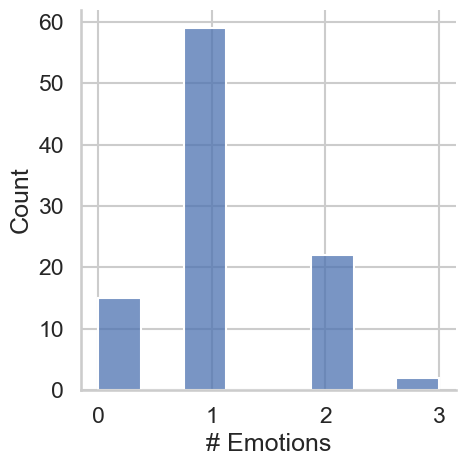

In [8]:
g = sns.displot(
    data=model_pred, 
    x="# Emotions",
)

In [9]:
print(
    "Report with at least one emotion: {:.1f} %".format(
        100*len(model_pred_no_z)/len(model_pred)
    )
)

Report with at least one emotion: 84.7 %


Emotion distribution in reports with at least one emotion

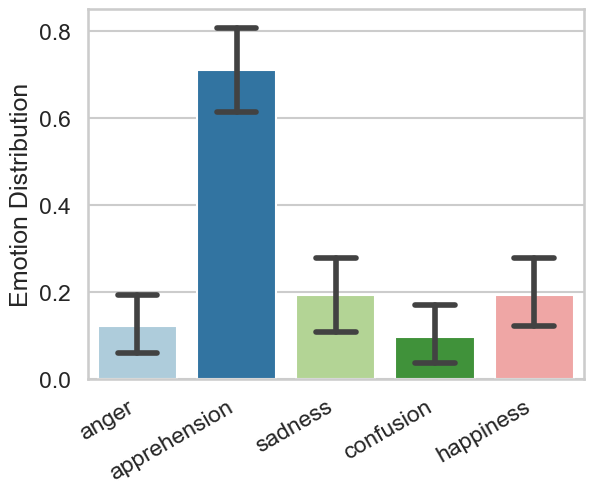

In [12]:
g = sns.barplot(
    data=model_pred_no_z[emotions_list], 
    capsize=.4, 
    linewidth=1.5,
    palette="Paired",
)
g.set(ylim=(0, .85))
g.set(ylabel="Emotion Distribution")
g.set_xticklabels(list(emotios.values()), rotation=30, horizontalalignment='right')
print()

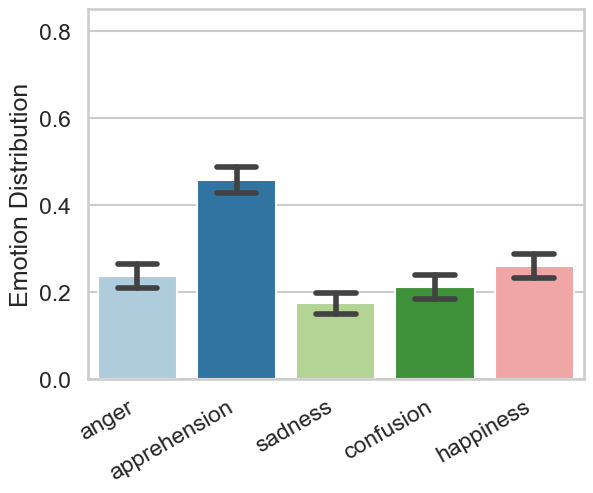

In [13]:
g = sns.barplot(
    data=data_G_df[emotions_list], 
    capsize=.4, 
    linewidth=1.5,
    palette="Paired",
)
g.set(ylim=(0, .85))
g.set(ylabel="Emotion Distribution")
g.set_xticklabels(list(emotios.values()), rotation=30, horizontalalignment='right')
print()

Merge, type 2

In [14]:
df = []
for idx, (an, ap, sd, co, ha, _, report, serie) in enumerate(merged_df.values):

    for em, am_presence in {"AN":an, "AP":ap, "SD":sd, "CO":co, "HA":ha}.items():
        if am_presence == 1:
            df.append(["report_{}".format(idx), serie, em])
        else: 
            continue
            
df = pd.DataFrame(
    df, 
    columns=["Report", "Series", "Emotion"]
)
df ["Type"] = [
    "Actual" if s != "Veteran (predicted)" else "Predicted" for 
    s in df["Series"].values
]
df.sample(2)

,Report,Series,Emotion,Type
1167,report_865,Hall/VdC Norms: Male,AP,Actual
1022,report_748,Hall/VdC Norms: Female,AP,Actual


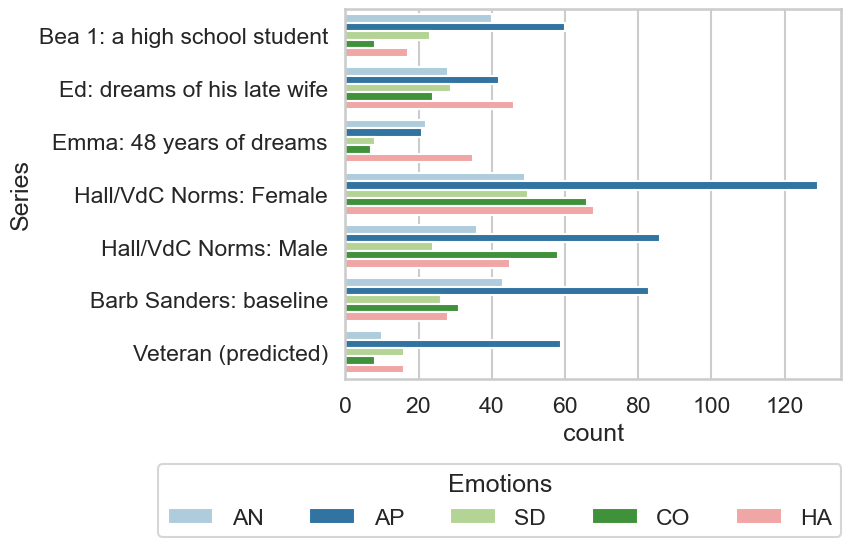

In [15]:
wth_v_COLLECTION_order = [
    "Bea 1: a high school student", "Ed: dreams of his late wife", "Emma: 48 years of dreams",
    "Hall/VdC Norms: Female", "Hall/VdC Norms: Male", "Barb Sanders: baseline", 
    "Veteran (predicted)"
]
g = sns.countplot(
    data=df,
    hue="Emotion",
    y="Series",
    hue_order=emotios,
    order=wth_v_COLLECTION_order,
    palette="Paired",
)

g.legend(title="Emotions", loc='center left', ncol=5, bbox_to_anchor=(-.4, -.33))

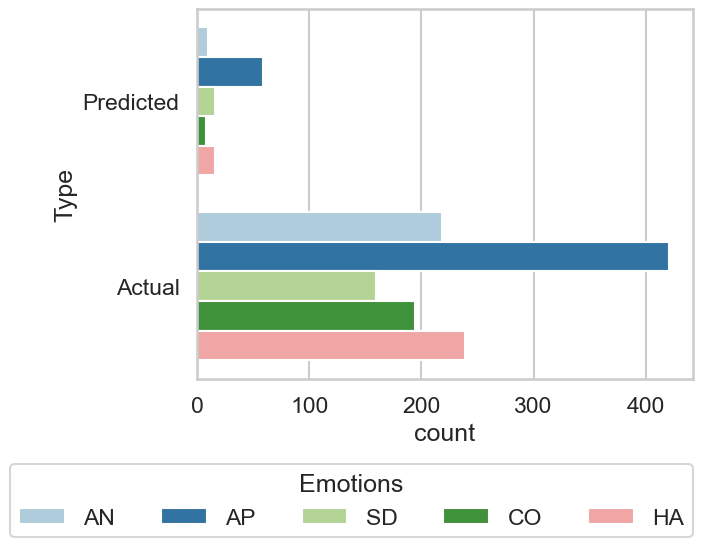

In [16]:
g = sns.countplot(
    data=df,
    hue="Emotion",
    y="Type",
    hue_order=emotios,
    palette="Paired",
)

g.legend(title="Emotions", loc='center left', ncol=5, bbox_to_anchor=(-.4, -.33))

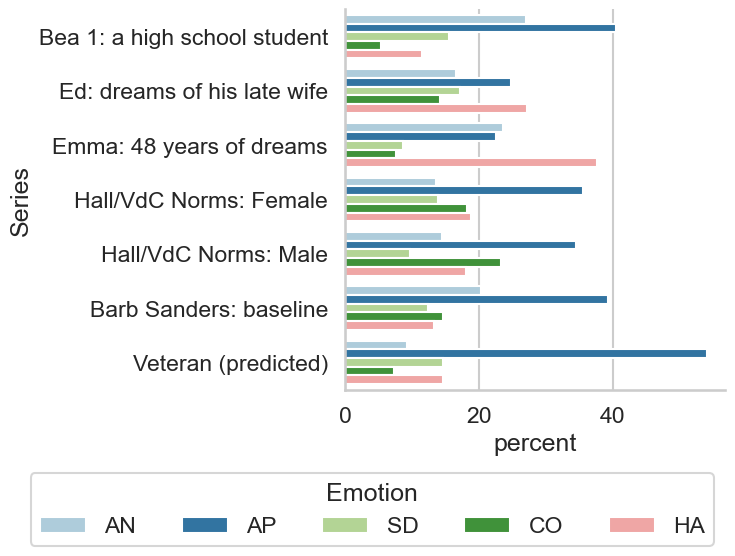

In [17]:
x,y = 'Series', 'Emotion'

g = (df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe(
    (sns.catplot,'data'), 
    y=x,
    x='percent',
    hue=y,
    kind='bar', 
    palette="Paired",
    order=wth_v_COLLECTION_order,
    hue_order=emotios,
)
)
g.fig.set_size_inches(50,5)
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.73, -.15), ncol=5, 
    frameon=True,
)

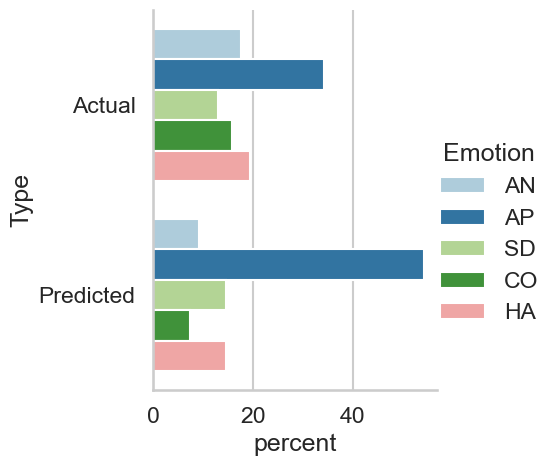

In [18]:
x,y = 'Type', 'Emotion'

g = (df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe(
    (sns.catplot,'data'), 
    y=x,
    x='percent',
    hue=y,
    kind='bar', 
    palette="Paired",
    hue_order=emotios,
)
)

Unpacking the distribution

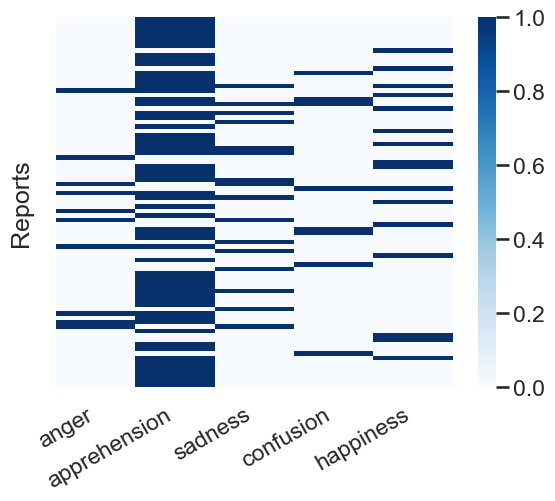

In [19]:
g = sns.heatmap(
    model_pred_no_z[emotions_list].values, 
    cmap="Blues"
)
g.set(ylabel="Reports", yticklabels="")
g.set_xticklabels(list(emotios.values()), rotation=30, horizontalalignment='right')
print()

Analysis of happiness-labelled dreams

In [20]:
print(
    "Report with at least one emotion, including happiness: {:.1f} %".format(
        100*len(model_pred_no_z[model_pred_no_z["HA"].isin([1])]) / len(model_pred_no_z)
    )
)

Report with at least one emotion, including happiness: 19.3 %


How many of these reports also contain apprehension?

In [21]:
model_pred_no_z[
    model_pred_no_z["HA"].isin([1]) & 
    model_pred_no_z["AP"].isin([1])
]

,AN,AP,SD,CO,HA,# Emotions,report,Series
20,0,1,1,0,1,3,I am with a friend. We have traveled to a str...,Veteran (predicted)
34,0,1,0,0,1,2,It is dark. I am with the platoon in a foreig...,Veteran (predicted)
40,0,1,0,0,1,2,A. man is lost at sea. I help to rescue him. ...,Veteran (predicted)
90,0,1,0,0,1,2,We are walking down a trail. Above and beyond...,Veteran (predicted)


List of the report labelled with happiness

In [23]:
for idx, report in enumerate(model_pred_no_z[model_pred_no_z["HA"].isin([1])]["report"]):
    print(idx, report)
    print("\n")

0  With a black man I am on a boat or the tip of an island, at war at sea. People are trying to kill us. I have several grenades strung together like a six pack of beer. I unhook one frag then activate one by pushing the safety off and pulling the pin, hurling the remaining grenades into the ocean. My aim is short but effective. There is a very big underwater explosion and subsequent whoosh and blast spout of water. We laugh and grin, knowing we have killed the enemy.                                                                                                                                                                                                                                                                                                                                                                                                                    


1  I am in my apartment in the Bronx, sleeping. I hear noise in the foyer. Two dolls, hanging from a doorknob, have come 

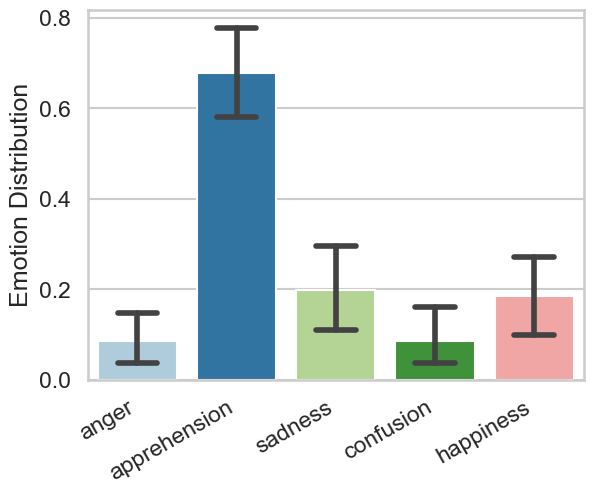

In [18]:
g = sns.barplot(
    data=model_pred_no_z[emotions_list], 
    capsize=.4, 
    linewidth=1.5,
    palette="Paired",
)
g.set(ylabel="Emotion Distribution")
g.set_xticklabels(list(emotios.values()), rotation=30, horizontalalignment='right')
print()